In [5]:
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba # 结巴分词
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")

D:\Anaconda\envs\python3.6\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
D:\Anaconda\envs\python3.6\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [6]:
# 使用gensim加载预训练中文分词embedding
corpus_path = r'D:\victor\Graduate\study\code\NLP\sgns.zhihu.bigram/'
cn_model = KeyedVectors.load_word2vec_format(corpus_path + 'sgns.zhihu.bigram', binary=False)

In [15]:
# 获得样本的索引，样本存放于两个文件夹中，
# 分别为 正面评价'pos'文件夹 和 负面评价'neg'文件夹
# neg文件夹中有7849个txt文件，每个文件中是一例评价
# pos文件夹中有7344个txt文件，每个文件中是一例评价
import os
path = (r'D:\victor\Graduate\study\code\web_data_mining\film_review\data')

pos_txts = os.listdir(os.path.join(path, 'pos'))
neg_txts = os.listdir(path + '/neg')
print(len(neg_txts))
print(len(pos_txts))

7849
7344


In [16]:
print( '样本总共: '+ str(len(pos_txts) + len(neg_txts)))

样本总共: 15193


In [17]:
# 将所有的评价内容放置到一个list里

train_texts_orig = [] # 存储所有评价，每例评价为一条string

# 添加完所有样本之后，train_texts_orig为一个含有15193条文本的list
# 其中前7849条文本为正面评价，后7344条为负面评价

for i in range(len(pos_txts)):
    with open(path +'/pos/'+pos_txts[i], 'r', errors='ignore', encoding='utf-8') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
for i in range(len(neg_txts)):
    with open(path +'/neg/'+neg_txts[i], 'r', errors='ignore', encoding='utf-8') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()

In [18]:
train_texts_orig[:10]

['电影比预期要更恢弘磅礴晨昏线过后的永夜火种计划让地球流浪木星推动地球等等大小设定没想到中国也能拍这么大架构大格局的科幻片了而且是第一部了不得以前看国外科幻感觉离我们很远这一次看到熟悉的北京大裤衩上海东方明珠都变成零下89°冰天冻地的末世场景既猎奇又唏嘘虽然在剧情上有套路对于这部中国文化背景下的科幻新生儿鼓励多于挑剔导演说美国人拍科幻是放弃地球去挖掘新的人类居住地而中国人是不放弃地球守住家土的情怀希望是我们回家的唯一方向',
 '125分钟重新定义了中国科幻主创团队站在好莱坞的肩膀上完成了一个中国电影人从未完成的壮举你可以在影片中看到《星际穿越》《全球风暴》《后天》《世界末日》等一系列好莱坞顶级大片的影子但是观看的时候你依然会非常明确地认定这是一部国产科幻大片应该具有的样子没有山寨感没有违和感编剧对于大刘故事的全新演绎面面俱到小到人物情感大到人类存亡都被演绎得让人信服高潮部分更是贡献了极强的情感穿透力燃度也是惊人说实话《流浪地球》作为国产科幻元年作品起点真的太高了心疼后面那些跃跃欲试的跟风者PS：小粉红请不要赞这条我不是你们盲目爱国的盟友',
 '一定要在电影院看的电影看2D配上好音效非常燃；部分特效确实看得出瑕疵但对于中国电影来说无疑是一大进步；希望导演的下一部戏不要这么多尴尬的煽情戏尽量不要请吴京了不是因为他又红又专而是因为他真的没什么演技',
 '简直比预期好太多斯皮尔伯格凭本事证明自己还是类型片大师把歪小子斯科特的概念商业类型片化了梗用得好有埋背景里的有直接台词致敬的也有真正服务剧情的当然也免不了配角功能化反派鸡肋结局太说教这些在这部片里不太重要的毛病',
 '这才是科这才是特所以黑豹和环太平到底是什',
 '对我而言音乐梗电影梗远比游戏要更燃当然这还是一个关于游戏死宅终极梦想的故事不要以为你是重氪玩家就能统治一切胜利是最终属于我们这些零氪geek的唯一不满的是故事结局太cliche了仿佛给我这种上班中途逃出来逃避死线的观影者当头一棒',
 '彩蛋多到数不过来太喜欢这种想象四溢的电',
 '有不满的地方：反面的力量完全地根植于从现实渗入过来的威胁恫吓仿佛虚拟世界再无矛盾可我们玩游戏何时又只剩想单调的快乐呢游戏本身源源不断予以我们的失望或焦躁应该可以成为更好的反派这与结尾的逻辑相一致现实需要教育虚拟然而啊游戏玩家又如何不能反问一句：现实何以代替虚拟',
 '

In [19]:
len(train_texts_orig)

15193

In [20]:
# 我们使用tensorflow的keras接口来建模
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional, CuDNNLSTM
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

**分词和tokenize**  
首先我们去掉每个样本的标点符号，然后用jieba分词，jieba分词返回一个生成器，没法直接进行tokenize，所以我们将分词结果转换成一个list，并将它索引化，这样每一例评价的文本变成一段索引数字，对应着预训练词向量模型中的词。

In [21]:
# 进行分词和tokenize
# train_tokens是一个长长的list，其中含有15193个小list，对应每一条评价
train_tokens = []
for text in train_texts_orig:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\wxphx\AppData\Local\Temp\jieba.cache
Loading model cost 1.082 seconds.
Prefix dict has been built succesfully.


**索引长度标准化**  
因为每段评语的长度是不一样的，我们如果单纯取最长的一个评语，并把其他评填充成同样的长度，这样十分浪费计算资源，所以我们取一个折衷的长度。

In [22]:
# 获得所有tokens的长度
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)

In [23]:
# 平均tokens的长度
np.mean(num_tokens)

31.483643783321266

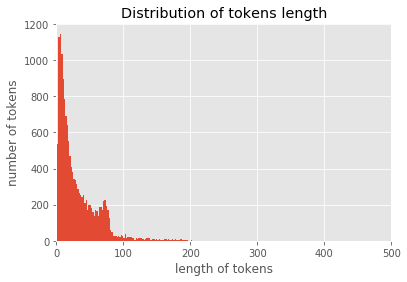

In [27]:
# plt.hist(np.log(num_tokens), bins = 100)  # 服从正态分布
plt.hist(num_tokens, bins = 100)
plt.xlim((0,500))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [28]:
# 取tokens平均值并加上两个tokens的标准差，
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

92

**准备Embedding Matrix**  
现在我们来为模型准备embedding matrix（词向量矩阵），根据keras的要求，我们需要准备一个维度为$(numwords, embeddingdim)$的矩阵，num words代表我们使用的词汇的数量，emdedding dimension在我们现在使用的预训练词向量模型中是300，每一个词汇都用一个长度为300的向量表示。  
注意我们只选择使用前50k个使用频率最高的词，在这个预训练词向量模型中，一共有260万词汇量，如果全部使用在分类问题上会很浪费计算资源，因为我们的训练样本很小，一共只有4k，如果我们有100k，200k甚至更多的训练样本时，在分类问题上可以考虑减少使用的词汇量。

In [34]:
embedding_dim

300

In [35]:
# 只使用前20000个词
num_words = 50000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [37]:
# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
embedding_matrix.shape

(50000, 300)

**padding（填充）和truncating（修剪）**  
我们把文本转换为tokens（索引）之后，每一串索引的长度并不相等，所以为了方便模型的训练我们需要把索引的长度标准化，上面我们选择了236这个可以涵盖95%训练样本的长度，接下来我们进行padding和truncating，我们一般采用'pre'的方法，这会在文本索引的前面填充0，因为根据一些研究资料中的实践，如果在文本索引后面填充0的话，会对模型造成一些不良影响。

In [38]:
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

In [39]:
# 超出五万个词向量的词用0代替
train_pad[ train_pad>=num_words ] = 0

In [40]:
# 可见padding之后前面的tokens全变成0，文本在最后面
train_pad[33]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,    55,     6,     0,
           0,    40,     0,     1,   196,   168, 12947,    38,    15,
          62,    12,   699,    45,   112,     0,   543,     0,     4,
         950,   197,   572,  1802,  6265,    15,  4505,     1,  4478,
          38,  1074,    15,  1169,     1,    87,    14,  4204,   480,
          32,  1355,     6,     7,    12,  4505,   277,     3,    34,
        2357,    38,   303,    34,  1896,   643,   543,   643,    93,
           1,   823])

In [41]:
# 准备target向量，前2000样本为1，后2000为0
train_target = np.concatenate( (np.ones(7344),np.zeros(7849)) )

In [42]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split

In [43]:
# 90%的样本用来训练，剩余10%用来测试
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12)

In [45]:
# 用LSTM对样本进行分类
model = Sequential()

In [46]:
# 模型第一层为embedding
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))

In [47]:
model.add(Bidirectional(CuDNNLSTM(units=32, return_sequences=True)))
model.add(CuDNNLSTM(units=16, return_sequences=False))

In [49]:
model.add(Dense(1, activation='sigmoid'))
# 我们使用adam以0.001的learning rate进行优化
optimizer = Adam(lr=1e-3)

In [50]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 92, 300)           15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 92, 64)            85504     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 16)                5248      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 15,090,769
Trainable params: 90,769
Non-trainable params: 15,000,000
_________________________________________________________________


In [67]:
# 开始训练
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

Train on 12305 samples, validate on 1368 samples
Epoch 1/20
12305/12305 [==============================] - 7s 571us/step - loss: 0.2824 - acc: 0.8840 - val_loss: 0.4627 - val_acc: 0.7895

Epoch 00001: val_loss did not improve from 0.44926
Epoch 2/20
12305/12305 [==============================] - 7s 554us/step - loss: 0.2813 - acc: 0.8850 - val_loss: 0.4640 - val_acc: 0.7887

Epoch 00002: val_loss did not improve from 0.44926
Epoch 3/20
12305/12305 [==============================] - 7s 553us/step - loss: 0.2803 - acc: 0.8852 - val_loss: 0.4642 - val_acc: 0.7902

Epoch 00003: val_loss did not improve from 0.44926
Epoch 4/20
12305/12305 [==============================] - 7s 552us/step - loss: 0.2793 - acc: 0.8855 - val_loss: 0.4656 - val_acc: 0.7880

Epoch 00004: val_loss did not improve from 0.44926
Epoch 00004: early stopping


**结论**  
我们首先对测试样本进行预测，得到了还算满意的准确度。  
之后我们定义一个预测函数，来预测输入的文本的极性，可见模型对于否定句和一些简单的逻辑结构都可以进行准确的判断。

In [68]:
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

1520/1520 [==============================] - 1s 541us/step
Accuracy:77.63%


In [100]:
def predict_sentiment(text):
    print(text)
    # 去标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    # 预测
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('是一例正面评价','output=%.2f'%coef)
    else:
        print('是一例负面评价','output=%.2f'%coef)

In [102]:
test_list = [
   '难看死了，千万别看，不推荐',
    '还可以啊，喜欢呀'
]
for text in test_list:
    predict_sentiment(text)

难看死了，千万别看，不推荐
是一例负面评价 output=0.05
还可以啊，喜欢呀
是一例正面评价 output=0.84
